In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy as sp
import scipy.stats
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import re
res_digit = r'[0-9]'

# fourier transform
from scipy.fft import fft, ifft

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE



In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")



thisdir = /home/luke/git/external/predicament/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/predicament/notebooks', '/home/luke/git/external/predicament', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## ensure relative path to data directory is sound
# for the notebook we need to modify the BASE_DATA_FOLDER
import os 
os.environ['PREDICAMENT_DATA_DIR'] =  '../data'

from predicament.utils.config import DREEM_EEG_CHANNELS

In [4]:
from predicament.data.timeseries import create_participant_data_edf_only
from predicament.data.windowed import window_all_participants_data
from predicament.data.windowed import merge_condition_data
from predicament.data.partitioning import between_subject_cv_partition

from predicament.data.features import MAXIMAL_FEATURE_GROUP
from predicament.data.features import STATS_FEATURE_GROUP
from predicament.data.features import INFO_FEATURE_GROUP
from predicament.data.features import FREQ_FEATURE_GROUP
from predicament.data.features import convert_timeseries_to_features
from prepare_evaluation_data import load_dataframe_and_config



## Convert to features

To be removed. This notebook focuses on learning

In [5]:
# from predicament.data.features import convert_timeseries_to_features

# feature_set = set(
#     ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
#      'Energy', 'IQR', 'Entropy', 'Hurst',
#     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
#     'FreqKurtosis', 'EnergyBands'])

# label_cols = ['part_ID', 'condition', 'start time']
# features_lol = []
# entropy_tol = 0.6
# for label_row, value_row in zip(
#         timeseries_df[label_cols].values.tolist(),
#         timeseries_df.loc[:, ~timeseries_df.columns.isin(label_cols)].values):
#     X = value_row.reshape((n_channels,-1))
#     features, feature_names = convert_timeseries_to_features(
#         X, feature_set, entropy_tol=entropy_tol, hurst_kind='random_walk')
#     features_lol.append(        
#             label_row + list(features))
# all_columns = label_cols + feature_names
# features_df = pd.DataFrame(features_lol,columns=all_columns)
# features_df.head()

NameError: name 'timeseries_df' is not defined

In [6]:
featured_df, featured_config = load_dataframe_and_config(
    '../data/featured/20231129210920/', 'featured.csv')
n_channels = int(featured_config['LOAD']['n_channels'])
channels = json.loads(featured_config['LOAD']['channels'].replace("'",'"'))
participant_list = json.loads(featured_config['LOAD']['participant_list'].replace("'",'"'))
Fs = int(featured_config['LOAD']['sample_rate'])
window_size = int(featured_config['LOAD']['window_size'])
time = window_size/Fs
print(f"Fs: {Fs}, n_samples = {window_size}, time: {time}s, n_channels: {n_channels}")


Fs: 250, n_samples = 1024, time: 4.096s, n_channels: 5


In [7]:
featured_df.columns

Index(['part_ID', 'condition', 'start time', 'Mean0', 'Mean1', 'Mean2',
       'Mean3', 'Mean4', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'MAD0', 'MAD1',
       'MAD2', 'MAD3', 'MAD4', 'Max0', 'Max1', 'Max2', 'Max3', 'Max4', 'Min0',
       'Min1', 'Min2', 'Min3', 'Min4', 'Energy0', 'Energy1', 'Energy2',
       'Energy3', 'Energy4', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'IQR4',
       'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3',
       'Correlation4', 'Correlation5', 'Correlation6', 'Correlation7',
       'Correlation8', 'Correlation9', 'arCoeff0', 'arCoeff1', 'arCoeff2',
       'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8',
       'arCoeff9', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13',
       'arCoeff14', 'arCoeff15', 'arCoeff16', 'arCoeff17', 'arCoeff18',
       'arCoeff19', 'LyapunovExponent0', 'LyapunovExponent1',
       'LyapunovExponent2', 'LyapunovExponent3', 'LyapunovExponent4',
       'MaxFreqInd0', 'MaxFreqInd1', 'MaxFreqInd2', 'MaxFreqI

In [8]:
features_to_use = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
      'Energy', 'IQR', # 'Entropy',
     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis' # , 'EnergyBands'
    ])
columns_to_use = [ col for col in featured_df.columns if re.sub(res_digit, '', col) in features_to_use ]
print(f"columns_to_use = {columns_to_use}")

designmtx = featured_df[columns_to_use].values 
condition_data = featured_df['condition'].values.astype(int)
subject_data_names = featured_df['part_ID']

design2d = TSNE(n_components=2, init='random', perplexity=3).fit_transform(designmtx)
print(f"design2d.shape = {design2d.shape}")

columns_to_use = ['Mean0', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'MAD4', 'Max0', 'Max1', 'Max2', 'Max3', 'Max4', 'Min0', 'Min1', 'Min2', 'Min3', 'Min4', 'Energy0', 'Energy1', 'Energy2', 'Energy3', 'Energy4', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'IQR4', 'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'Correlation6', 'Correlation7', 'Correlation8', 'Correlation9', 'arCoeff0', 'arCoeff1', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff16', 'arCoeff17', 'arCoeff18', 'arCoeff19', 'MaxFreqInd0', 'MaxFreqInd1', 'MaxFreqInd2', 'MaxFreqInd3', 'MaxFreqInd4', 'MeanFreq0', 'MeanFreq1', 'MeanFreq2', 'MeanFreq3', 'MeanFreq4', 'FreqSkewness0', 'FreqSkewness1', 'FreqSkewness2', 'FreqSkewness3', 'FreqSkewness4', 'FreqKurtosis0', 'FreqKurtosis1', 'FreqKurtosis2', '

designmtx.shape = (27304, 85)
condition_data.shape = (27304,)
subject_data.shape = (27304,)


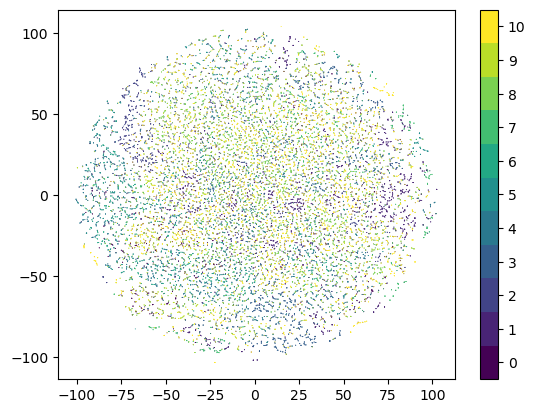

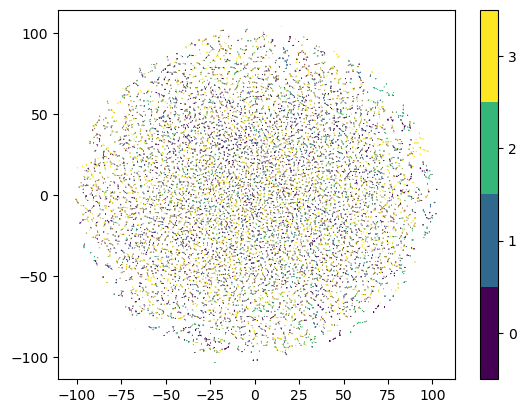

In [9]:
subjects = np.unique(subject_data_names)
subject_data = np.empty(subject_data_names.shape, dtype=int)
for s, sub in enumerate(subjects):
    subject_data[subject_data_names==sub] = s
print(f"designmtx.shape = {designmtx.shape}")
print(f"condition_data.shape = {condition_data.shape}")
print(f"subject_data.shape = {subject_data.shape}")
    
conditions = np.unique(condition_data)
markers = ['v', '^', '<', '>', 's', '*', '+' , 'x', 'D', '.']
colours = ['b','g','r','y','k']
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(np.min(subject_data)-0.5,np.max(subject_data)+0.5), cmap.N)

plt.scatter(
    design2d[:,0], design2d[:,1], c=subject_data, norm=norm, s=0.5, edgecolor='none')
plt.colorbar(
    ticks=np.arange(subjects.size))


plt.figure()
cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(np.min(condition_data)-0.5,np.max(condition_data)+0.5), cmap.N)

plt.scatter(
    design2d[:,0], design2d[:,1], c=condition_data, norm=norm, s=0.5, edgecolor='none')
plt.colorbar(
    ticks=np.arange(conditions.size))
# for s,subject in enumerate(subjects):
#     marker = s
#     for c, condition in enumerate(conditions):
#         _filter = (condition_data==condition) &(subject_data==subject)
#         #print(f"condition = {condition}")
#         #print(f"np.sum(_filter) = {np.sum(_filter)}")
#         plt.plot(design2d[_filter,0], design2d[_filter,1], ls='None', marker=markers[s], color=colours[c], markeredgewidth=0.1)
        

## Classification

In [10]:
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import GroupKFold

models = {
    "Random Forest": RandomForestClassifier(
        min_samples_leaf=5, random_state=0
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        max_leaf_nodes=15, random_state=0
    ),
    "MLP":  MLPClassifier(max_iter=100)
}
param_grids = {
    "Random Forest": {"n_estimators": [10, 20, 50, 100]},
    "Gradient Boosting": {"n_estimators": [10, 20, 50, 100]},
    "MLP": {
        'hidden_layer_sizes': [(10,),(20,),(50,),(100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
}



In [11]:
# # standard cross-validation
# # Match all digits in the string and replace them with an empty string
# # new_string = re.sub(pattern, '', string1)
# results_df = None

# features_to_use = set(
#     ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
#       'Energy', 'IQR', # 'Entropy',
#      'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
#     'FreqKurtosis' # , 'EnergyBands'
#     ])
# columns_to_use = [ col for col in featured_df.columns if re.sub(res_digit, '', col) in features_to_use ]
# print(f"columns_to_use = {columns_to_use}")

# designmtx = featured_df[columns_to_use].values 
# # condition_data = featured_df['condition'].values.astype(int)
# # subject_data = featured_df['subject'].values.astype(int)

# cv = KFold(n_splits=5, shuffle=True, random_state=0)
# results = []
# for name, model in models.items():
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grids[name],
#         return_train_score=True,
#         cv=cv,
#     ).fit(designmtx, condition_data)
#     result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
#     results.append(result)

In [12]:
# print(f"results[0]['mean_test_score'] ={results[0]['mean_test_score']}")
# print(f"results[1]['mean_test_score'] ={results[1]['mean_test_score']}")


## Hold one group out

In [13]:
# standard cross-validation
# Match all digits in the string and replace them with an empty string
# new_string = re.sub(pattern, '', string1)
subjects = np.unique(featured_df['part_ID'])
n_subjects = len(subjects)
groups = np.empty(len(featured_df), dtype=int)
for s, sub in enumerate(subjects):
    groups[featured_df['part_ID']==sub] = s
    
features_to_use = set(
    ['Mean', 'SD', 'MAD', 'Max', 'Min',# 'SMA',
      'Energy', 'IQR', # 'Entropy',
     'arCoeff', 'Correlation', 'MaxFreqInd', 'MeanFreq', 'FreqSkewness',
    'FreqKurtosis' # , 'EnergyBands'
    ])
columns_to_use = [ col for col in featured_df.columns if re.sub(res_digit, '', col) in features_to_use ]
print(f"columns_to_use = {columns_to_use}")

designmtx = featured_df[columns_to_use].values 

columns_to_use = ['Mean0', 'Mean1', 'Mean2', 'Mean3', 'Mean4', 'SD0', 'SD1', 'SD2', 'SD3', 'SD4', 'MAD0', 'MAD1', 'MAD2', 'MAD3', 'MAD4', 'Max0', 'Max1', 'Max2', 'Max3', 'Max4', 'Min0', 'Min1', 'Min2', 'Min3', 'Min4', 'Energy0', 'Energy1', 'Energy2', 'Energy3', 'Energy4', 'IQR0', 'IQR1', 'IQR2', 'IQR3', 'IQR4', 'Correlation0', 'Correlation1', 'Correlation2', 'Correlation3', 'Correlation4', 'Correlation5', 'Correlation6', 'Correlation7', 'Correlation8', 'Correlation9', 'arCoeff0', 'arCoeff1', 'arCoeff2', 'arCoeff3', 'arCoeff4', 'arCoeff5', 'arCoeff6', 'arCoeff7', 'arCoeff8', 'arCoeff9', 'arCoeff10', 'arCoeff11', 'arCoeff12', 'arCoeff13', 'arCoeff14', 'arCoeff15', 'arCoeff16', 'arCoeff17', 'arCoeff18', 'arCoeff19', 'MaxFreqInd0', 'MaxFreqInd1', 'MaxFreqInd2', 'MaxFreqInd3', 'MaxFreqInd4', 'MeanFreq0', 'MeanFreq1', 'MeanFreq2', 'MeanFreq3', 'MeanFreq4', 'FreqSkewness0', 'FreqSkewness1', 'FreqSkewness2', 'FreqSkewness3', 'FreqSkewness4', 'FreqKurtosis0', 'FreqKurtosis1', 'FreqKurtosis2', '

In [14]:
results_df = pd.DataFrame()
group_kfold = GroupKFold(n_splits=n_subjects)
results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=group_kfold,
    ).fit(X=designmtx, y=condition_data, groups=groups)
    result_df = pd.DataFrame(grid_search.cv_results_)
    #test_df['model'] = result['model']
    result_df.insert(0, 'model', name)
    result_df.insert(1, 'held out', 'subject')
    result_df.insert(2, 'feature set', str(features_to_use))
    display(result_df)
    results_df = pd.concat((results_df, result_df))
    #result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    #results.append(result)

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,Random Forest,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",1.707944,0.036421,0.004250,0.000424,10,{'n_estimators': 10},0.228077,...,0.975604,0.975081,0.977220,0.975895,0.975461,0.976855,0.977054,0.976514,0.976208,0.000977
1,Random Forest,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",3.295461,0.082104,0.007195,0.000735,20,{'n_estimators': 20},0.226948,...,0.987541,0.986255,0.987011,0.988126,0.986957,0.987952,0.988527,0.986823,0.987067,0.000793
2,Random Forest,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",8.229823,0.211391,0.016079,0.001790,50,{'n_estimators': 50},0.229582,...,0.992243,0.991922,0.992686,0.993090,0.991397,0.992787,0.992800,0.991823,0.992171,0.000580
3,Random Forest,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",16.474487,0.450618,0.030744,0.003360,100,{'n_estimators': 100},0.228077,...,0.993368,0.993730,0.993965,0.994321,0.993300,0.994293,0.993433,0.993024,0.993554,0.000538


,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,Gradient Boosting,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",29.881684,0.436505,0.002458,0.000269,10,{'n_estimators': 10},0.278886,...,0.488566,0.498814,0.486932,0.507982,0.494589,0.510938,0.484907,0.499516,0.497644,0.011167
1,Gradient Boosting,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",60.174890,0.992162,0.003357,0.000338,20,{'n_estimators': 20},0.210388,...,0.558740,0.562397,0.551874,0.568978,0.560436,0.567930,0.554259,0.558811,0.562565,0.009245
2,Gradient Boosting,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",151.884011,2.611321,0.006105,0.000740,50,{'n_estimators': 50},0.199849,...,0.655520,0.661549,0.664935,0.667064,0.672706,0.669230,0.658108,0.663140,0.665916,0.009319
3,Gradient Boosting,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",367.647425,89.463882,0.013451,0.003035,100,{'n_estimators': 100},0.212646,...,0.735581,0.737310,0.752378,0.751449,0.746720,0.757173,0.742098,0.746347,0.748539,0.009895


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",1.634825,0.055609,0.007102,0.003549,tanh,0.0001,"(10,)",...,0.327117,0.327117,0.325274,0.322492,0.322656,0.322567,0.322388,0.346936,0.327839,0.006718
1,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",3.607828,2.275702,0.007942,0.003958,tanh,0.0001,"(10,)",...,0.330574,0.327117,0.325274,0.322453,0.322656,0.322567,0.322388,0.346859,0.328641,0.007095
2,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",8.291579,0.856053,0.008271,0.003865,tanh,0.0001,"(10,)",...,0.327117,0.327117,0.325234,0.322413,0.322656,0.322567,0.322388,0.346898,0.327822,0.006712
3,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",2.563920,1.840913,0.007836,0.003664,tanh,0.0001,"(10,)",...,0.327117,0.327117,0.325274,0.322453,0.322616,0.322765,0.322348,0.346936,0.327845,0.006714
4,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",9.719281,2.178515,0.014906,0.007059,tanh,0.0001,"(20,)",...,0.327117,0.327117,0.325274,0.322294,0.322656,0.322606,0.322388,0.346936,0.327825,0.006728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",9.816935,2.481619,0.003675,0.000439,relu,0.05,"(50,)",...,0.352317,0.244202,0.365958,0.284012,0.229217,0.354708,0.284844,0.216641,0.302476,0.056763
60,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",6.184372,1.269436,0.005246,0.001740,relu,0.05,"(100,)",...,0.327117,0.327117,0.325274,0.322572,0.322696,0.322567,0.322388,0.346936,0.327855,0.006709
61,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",9.452597,2.405954,0.004761,0.000591,relu,0.05,"(100,)",...,0.378080,0.302440,0.301854,0.301247,0.238494,0.353480,0.252245,0.187226,0.300726,0.066444
62,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",17.473506,1.885943,0.004753,0.000511,relu,0.05,"(100,)",...,0.327077,0.327117,0.325274,0.322453,0.322656,0.322606,0.322388,0.346936,0.327839,0.006719


In [15]:
results_df

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,...,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver
0,Random Forest,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",1.707944,0.036421,0.004250,0.000424,10,{'n_estimators': 10},0.228077,...,0.976855,0.977054,0.976514,0.976208,0.000977,NaN,NaN,NaN,NaN,NaN
1,Random Forest,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",3.295461,0.082104,0.007195,0.000735,20,{'n_estimators': 20},0.226948,...,0.987952,0.988527,0.986823,0.987067,0.000793,NaN,NaN,NaN,NaN,NaN
2,Random Forest,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",8.229823,0.211391,0.016079,0.001790,50,{'n_estimators': 50},0.229582,...,0.992787,0.992800,0.991823,0.992171,0.000580,NaN,NaN,NaN,NaN,NaN
3,Random Forest,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",16.474487,0.450618,0.030744,0.003360,100,{'n_estimators': 100},0.228077,...,0.994293,0.993433,0.993024,0.993554,0.000538,NaN,NaN,NaN,NaN,NaN
0,Gradient Boosting,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",29.881684,0.436505,0.002458,0.000269,10,{'n_estimators': 10},0.278886,...,0.510938,0.484907,0.499516,0.497644,0.011167,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",9.816935,2.481619,0.003675,0.000439,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.284155,...,0.354708,0.284844,0.216641,0.302476,0.056763,relu,0.05,"(50,)",adaptive,adam
60,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",6.184372,1.269436,0.005246,0.001740,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.305984,...,0.322567,0.322388,0.346936,0.327855,0.006709,relu,0.05,"(100,)",constant,sgd
61,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",9.452597,2.405954,0.004761,0.000591,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.305231,...,0.353480,0.252245,0.187226,0.300726,0.066444,relu,0.05,"(100,)",constant,adam
62,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",17.473506,1.885943,0.004753,0.000511,NaN,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.305984,...,0.322606,0.322388,0.346936,0.327839,0.006719,relu,0.05,"(100,)",adaptive,sgd


In [16]:
import datetime
nowstr = datetime.datetime.now().replace(microsecond=0).isoformat()
results_df.to_csv(f'../data/results/{nowstr}_results.csv')

In [17]:
results_df[results_df['model'] == 'Random Forest']['mean_test_score'].max()

0.2642049624451031

In [18]:
results_df[results_df['model'] == 'Gradient Boosting']['mean_test_score'].max()

0.285403698431337

In [19]:
results_df[results_df['model'] == 'MLP']['mean_test_score'].max()

0.34125402248018366

In [31]:
name = "MLP"  
mlp_param_grid = dict(
    hidden_layer_sizes=[(10*i,) for i in range(1,21)],
#     activation=['tanh', 'relu'],
#     solver=['sgd', 'adam'],
    alpha=np.logspace(-5,-1,13),
#     learning_rate=['constant','adaptive'],
    #learning_rate_init=np.logspace(-5,-1,13),
    max_iter=[50, 100, 150, 200]
    )

for param in mlp_param_grid.keys():
    these_static_params = { k:v for k, v in mlp_best_params.items() if k != param }
    model = MLPClassifier(**these_static_params)
    this_param_grid = { k:v for k,v in mlp_param_grid.items() if k == param }
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=this_param_grid,
        return_train_score=True,
        cv=group_kfold,
    ).fit(X=designmtx, y=condition_data, groups=groups)
    result_df = pd.DataFrame(grid_search.cv_results_)
    #test_df['model'] = result['model']
    result_df.insert(0, 'model', name)
    result_df.insert(1, 'held out', 'subject')
    result_df.insert(2, 'feature set', str(features_to_use))
    display(result_df)
    results_df = pd.concat((results_df, result_df))


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",8.691961,5.301315,0.010619,0.008678,"(10,)","{'hidden_layer_sizes': (10,)}",0.221302,...,0.330493,0.369358,0.231117,0.376658,0.334985,0.341867,0.319777,0.283223,0.326317,0.042172
1,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",14.355837,3.819234,0.005529,0.006033,"(20,)","{'hidden_layer_sizes': (20,)}",0.173880,...,0.356658,0.373337,0.368396,0.364268,0.376452,0.370046,0.255964,0.352130,0.351444,0.037117
2,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",11.481090,2.998021,0.003119,0.000306,"(30,)","{'hidden_layer_sizes': (30,)}",0.298081,...,0.348338,0.297938,0.264527,0.363355,0.328206,0.329661,0.369625,0.241057,0.323543,0.046056
3,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",10.564917,3.070676,0.003357,0.000386,"(40,)","{'hidden_layer_sizes': (40,)}",0.301091,...,0.283309,0.392106,0.335705,0.330990,0.233895,0.326371,0.274321,0.364376,0.319600,0.052219
4,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",11.265598,3.724677,0.003570,0.000452,"(50,)","{'hidden_layer_sizes': (50,)}",0.188935,...,0.373578,0.347534,0.368356,0.388571,0.326620,0.245720,0.369427,0.360578,0.332900,0.047832
5,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",10.025555,1.994197,0.003945,0.000685,"(60,)","{'hidden_layer_sizes': (60,)}",0.179149,...,0.369037,0.263253,0.254856,0.366373,0.364202,0.337706,0.351861,0.212882,0.325200,0.051872
6,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",10.220158,2.787013,0.004269,0.000834,"(70,)","{'hidden_layer_sizes': (70,)}",0.253670,...,0.310960,0.375789,0.357845,0.356485,0.306283,0.213737,0.316572,0.187033,0.320461,0.058174
7,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",11.264733,3.940030,0.004208,0.000472,"(80,)","{'hidden_layer_sizes': (80,)}",0.175762,...,0.279812,0.370926,0.224922,0.358947,0.345847,0.295696,0.248843,0.341511,0.318369,0.049364
8,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",10.665600,3.996551,0.005290,0.002409,"(90,)","{'hidden_layer_sizes': (90,)}",0.286037,...,0.364937,0.259636,0.310127,0.281550,0.227869,0.366241,0.310084,0.171957,0.304496,0.065576
9,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",8.353285,2.622017,0.004772,0.000602,"(100,)","{'hidden_layer_sizes': (100,)}",0.269853,...,0.330011,0.221615,0.329270,0.237193,0.350723,0.271164,0.234719,0.358253,0.304114,0.053403


,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",18.090671,5.820280,0.003955,0.001448,0.00001,{'alpha': 1e-05},0.206624,...,0.365862,0.359632,0.274838,0.344969,0.328722,0.349120,0.371444,0.363562,0.338214,0.027341
1,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",21.684330,8.514172,0.003601,0.001060,0.000022,{'alpha': 2.1544346900318823e-05},0.237862,...,0.380330,0.393192,0.360763,0.333413,0.368523,0.364022,0.361989,0.226175,0.356576,0.042630
2,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",21.781449,8.883275,0.003543,0.000704,0.000046,{'alpha': 4.641588833612782e-05},0.275499,...,0.362325,0.387283,0.241308,0.371932,0.343667,0.303622,0.360723,0.351858,0.351930,0.041816
3,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",22.803125,10.416929,0.012288,0.014688,0.0001,{'alpha': 0.0001},0.291682,...,0.341626,0.308348,0.268923,0.352434,0.308266,0.372662,0.384816,0.368291,0.326147,0.057872
4,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",20.801243,5.477826,0.007801,0.008723,0.000215,{'alpha': 0.00021544346900318823},0.209259,...,0.314939,0.377316,0.279314,0.375228,0.361784,0.349873,0.372236,0.230942,0.333470,0.043701
5,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",17.678999,5.460023,0.006818,0.008695,0.000464,{'alpha': 0.00046415888336127773},0.171246,...,0.367951,0.366585,0.372512,0.366055,0.364163,0.369570,0.232979,0.357439,0.350611,0.042298
6,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",21.242397,12.775585,0.010905,0.014363,0.001,{'alpha': 0.001},0.245766,...,0.364696,0.377839,0.348893,0.346279,0.355362,0.383719,0.330696,0.197613,0.342270,0.051347
7,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",16.072567,3.601367,0.003959,0.001233,0.002154,{'alpha': 0.002154434690031882},0.295070,...,0.364053,0.378120,0.278355,0.354738,0.367810,0.370878,0.352494,0.167500,0.337902,0.061889
8,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",17.489381,6.102416,0.006021,0.004792,0.004642,{'alpha': 0.004641588833612777},0.281521,...,0.366223,0.269041,0.348014,0.284251,0.374787,0.345751,0.360723,0.218114,0.335997,0.048994
9,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",24.789080,11.537782,0.011062,0.012179,0.01,{'alpha': 0.01},0.288671,...,0.371810,0.390619,0.245344,0.256175,0.369158,0.305683,0.357004,0.245437,0.338711,0.056035


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimize

,model,held out,feature set,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,params,split0_test_score,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",13.216922,0.906459,0.003890,0.001150,50,{'max_iter': 50},0.304855,...,0.344480,0.366906,0.264008,0.363514,0.350842,0.279249,0.330854,0.365810,0.331993,0.036173
1,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",19.547398,4.075492,0.004644,0.002494,100,{'max_iter': 100},0.293941,...,0.355171,0.371770,0.288786,0.315185,0.316710,0.361763,0.339558,0.195636,0.330025,0.047765
2,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",17.181892,5.983858,0.003632,0.000992,150,{'max_iter': 150},0.198720,...,0.357140,0.388851,0.362601,0.326106,0.344381,0.381737,0.263837,0.136263,0.329887,0.066593
3,MLP,subject,"{'MaxFreqInd', 'Energy', 'Mean', 'FreqSkewness...",24.029834,6.562469,0.005724,0.003530,200,{'max_iter': 200},0.222808,...,0.357100,0.388328,0.329310,0.365142,0.309534,0.346267,0.316928,0.378406,0.348432,0.032108


In [32]:
mlp_max_test_score = results_df[results_df['model'] == 'MLP']['mean_test_score'].max()
print(f"mlp_max_test_score= {mlp_max_test_score}")
d = results_df[results_df['mean_test_score'] == mlp_max_test_score]['params']
for k,v in d.items():
    mlp_best_params = v
    print(f"best params: {v}")

mlp_max_test_score= 0.34374303778718057
best params: {'max_iter': 100}


In [34]:
results_df[results_df['mean_test_score'] == mlp_max_test_score]['model']

1    MLP
Name: model, dtype: object

In [41]:
tot = len(featured_df)
for part_ID in subjects: 
    subj_featured_df = featured_df[featured_df['part_ID'] == part_ID]
    for c in np.unique(featured_df['condition']):
        count = len(subj_featured_df[subj_featured_df['condition'] == c])
        print(f"count = {count}")
        print(f"{s}-{c} : {count}/{tot} = {count/tot}")

count = 813
11-0 : 813/27304 = 0.029775857017286845
count = 461
11-1 : 461/27304 = 0.016883973044242603
count = 461
11-2 : 461/27304 = 0.016883973044242603
count = 461
11-3 : 461/27304 = 0.016883973044242603
count = 461
11-4 : 461/27304 = 0.016883973044242603
count = 813
11-0 : 813/27304 = 0.029775857017286845
count = 344
11-1 : 344/27304 = 0.01259888661002051
count = 461
11-2 : 461/27304 = 0.016883973044242603
count = 559
11-3 : 559/27304 = 0.02047319074128333
count = 461
11-4 : 461/27304 = 0.016883973044242603
count = 813
11-0 : 813/27304 = 0.029775857017286845
count = 110
11-1 : 110/27304 = 0.004028713741576326
count = 344
11-2 : 344/27304 = 0.01259888661002051
count = 461
11-3 : 461/27304 = 0.016883973044242603
count = 344
11-4 : 344/27304 = 0.01259888661002051
count = 813
11-0 : 813/27304 = 0.029775857017286845
count = 227
11-1 : 227/27304 = 0.008313800175798417
count = 461
11-2 : 461/27304 = 0.016883973044242603
count = 461
11-3 : 461/27304 = 0.016883973044242603
count = 461
11-4

In [40]:
3337//11

303